# Xarray-spatial
### User Guide: Pathfinding
-----

Xarray-spatial's Pathfinding provides a comprehensive tool for finding the shortest path from one point to another in a raster that can contain any level of complex boundaries or obstacles amidst an interconnected set of traversable path segments.

[A* Pathfinding](#A*)

-----------


#### Let's use datashader to render our images...

First, we'll import some basic packages and some functions from datashader for image rendering.

In [1]:
import numpy as np
import pandas as pd

import datashader as ds
from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
from datashader.transfer_functions import dynspread
from datashader.transfer_functions import set_background
from datashader.colors import Elevation

import xrspatial

To download the examples data, run the command `xrspatial examples` in your terminal. All the data will be stored in your current directory inside a folder named `xrspatial-examples`.

## A*

A* is an informed search algorithm, or a best-first search, meaning that it is formulated in terms of weighted graphs: starting from a specific starting node of a graph, it aims to find a path to the given goal node having the smallest cost (min distance travelled, shortest time, ...). 

The `xrspatial.a_star_search` function calculates the shortest path in pixel space from a start location to a goal location through a given aggregate surface graph. The graph should be a line raster which contains crossable and non-crossable (a.k.a walls or barrieres) values. Note that both start and goal are in (lon, lat), or (x, y) coordinate space and must be within the graph. `xrspatial.a_star_search` provides 2 separate options, `snap_start` and `snap_goal`, which can be set to true to snap locations to the nearest valid value before beginning pathfinding. It also provides a `connectivity` option to indicate neighborhood structure. This value can be set to 4 or 8 for 4-connectivity or 8-connectivity.

Let's generate a fake line raster and find the shortest path with A*.

- First, we'll generate a line raster by setting up a pandas DataFrame specifying the line coordinates.
- Then, we'll aggregate that into a lines raster with Canvas.line
- Once we have that, we'll choose a start and goal point to put into the a* pathfinding function.
- For visualization, we'll also aggregate those points and render them in an image together with the lines.

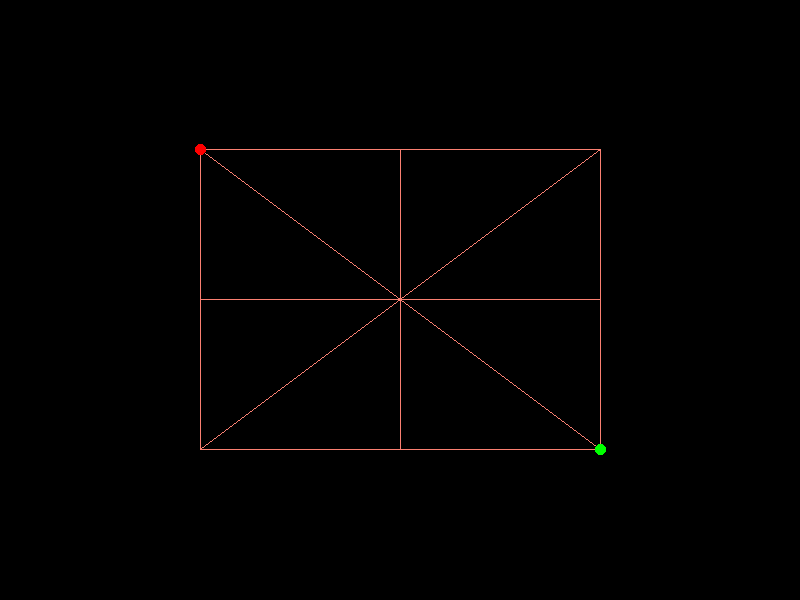

In [2]:
from xrspatial import a_star_search

# define range of x and y
xrange = (0, 4)
yrange = (0, 4)

# create line raster
ys = [1, 1, 3, 3, 1, 1, np.nan, 1, 3, np.nan, 1, 3, np.nan, 1, 3, np.nan, 2, 2]
xs = [1, 3, 3, 1, 1, 3, np.nan, 1, 3, np.nan, 3, 1, np.nan, 2, 2, np.nan, 1, 3]
line_df = pd.DataFrame(dict(x=xs, y=ys))

W = 800
H = 600
cvs = ds.Canvas(plot_width=W, plot_height=H, x_range=xrange, y_range=yrange)
line_agg = cvs.line(line_df, x="x", y="y").astype(int)
line_shaded = dynspread(shade(line_agg, cmap=["black", "salmon"]))

# pick up 2 random locations
start = (3, 1)
goal = (1, 3)

start_df = pd.DataFrame({"x": [start[1]], "y": [start[0]]})
start_agg = cvs.points(start_df, "x", "y")
start_shaded = dynspread(shade(start_agg, cmap=["red"]), threshold=1, max_px=5)

goal_df = pd.DataFrame({"x": [goal[1]], "y": [goal[0]]})
goal_agg = cvs.points(goal_df, "x", "y")
goal_shaded = dynspread(shade(goal_agg, cmap=["lime"]), threshold=1, max_px=5)

set_background(stack(line_shaded, start_shaded, goal_shaded), "black")

We're now ready to apply `a_star_search`.

### Calculating the 8-connectivity shortest path:

- To calculate the path, we input the line raster and the start and goal point coordinates.
- We also set the barriers; i.e. cells that are not crossable. In our case, any cell with a value of 0 (all the black non-line cells).
- Finally, we'll also set snap_start and snap_goal to True.
- Note: since `a_star_search` uses 8-connectivity by default, we don't need to pass that in.

The shortest path is highlighted in the rendering below.

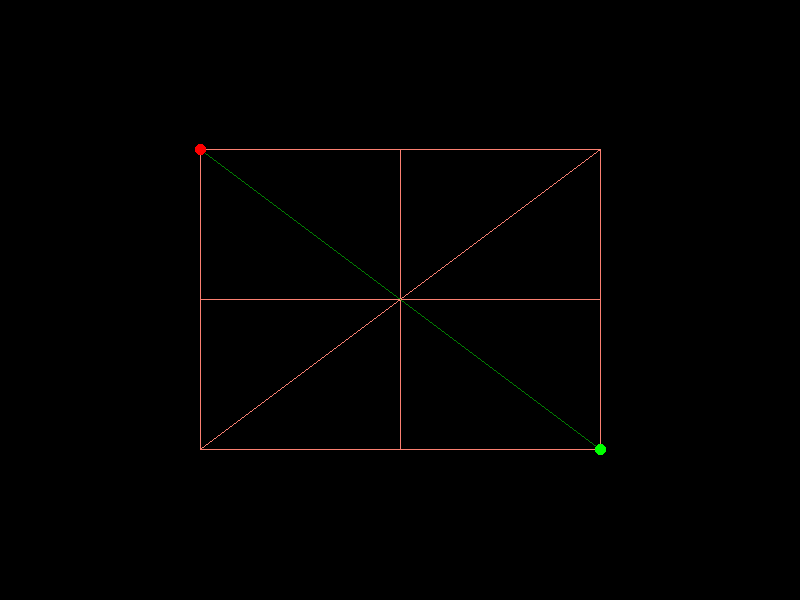

In [3]:
# find the path from start to goal,
# barriers are uncrossable cells. In this case, they are cells with a value of 0

path_agg_8_connectivity = a_star_search(
    line_agg, start, goal, barriers=[0], snap_start=True, snap_goal=True
)

path_shaded = dynspread(shade(path_agg_8_connectivity, cmap=["green"]))
set_background(stack(line_shaded, path_shaded, start_shaded, goal_shaded), "black")

### 4-connectivity

For 4-connectivity distance, we use the same arguments as above, but set the connectivity to 4.

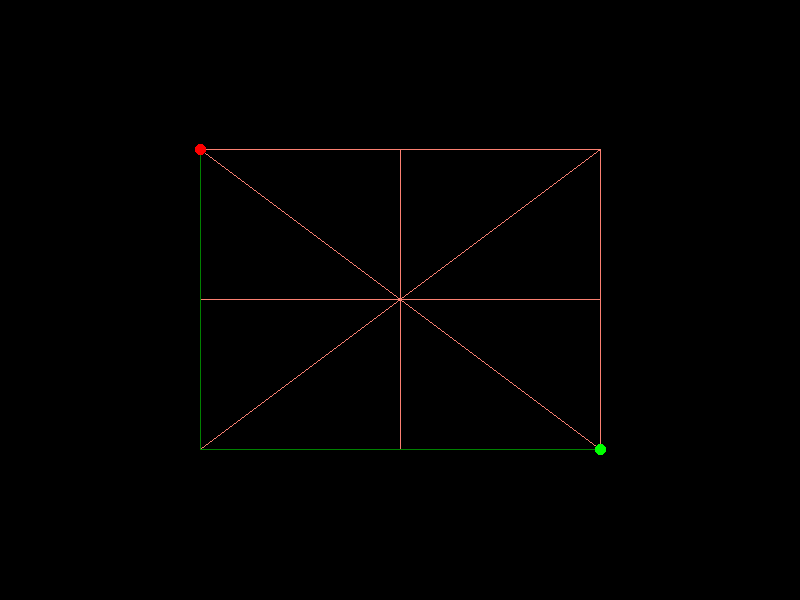

In [4]:
# find the path from start to goal,
# barriers are uncrossable cells. In this case, they are cells with a value of 0

path_agg_4_connectivity = a_star_search(
    line_agg, start, goal, barriers=[0], snap_start=True, snap_goal=True, connectivity=4
)

path_shaded = dynspread(shade(path_agg_4_connectivity, cmap=["green"]))
set_background(stack(line_shaded, path_shaded, start_shaded, goal_shaded), "black")




### References

- A* search algorithm: https://en.wikipedia.org/wiki/A*_search_algorithm